In [72]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
import random
from numpy.random import choice
random.seed(10)
np.random.seed(10)
import math
%matplotlib inline

### Load Data

In [73]:
demands = pd.read_excel(open('demands21.xlsx', 'rb'))
assuta_items = pd.read_excel("Assuta_items.xlsx")
refresh_21 = pd.read_excel("refresh21.xlsx")
refresh_22 = pd.read_excel("refresh22.xlsx")
initial_inventory = pd.read_excel("Initial_inventory.xls")
daily_demands_22 = pd.read_excel("daily demands 22.xlsx")
volumes = pd.read_excel("volume.xlsx")

### Pre Processing

In [74]:
# fill nulls, rename, merge, slicing

demands.fillna(0,inplace=True)

assuta_items = pd.DataFrame(assuta_items.iloc[:,0])

refresh_21.rename(columns = {f'{refresh_21.columns[0]}':'SKU_ID'}, inplace = True)
refresh_22.rename(columns = {f'{refresh_22.columns[0]}':'SKU_ID'}, inplace = True)
refresh = pd.merge(refresh_21, refresh_22, on ='SKU_ID', how ='inner')
refresh.fillna(0,inplace=True)

initial_inventory = initial_inventory.loc[:,['SKU','Total Qty']]
initial_inventory.rename(columns = {f'{initial_inventory.columns[0]}':'SKU_ID',f'{initial_inventory.columns[1]}':'Total Qty'}, inplace = True)

daily_demands_22.rename(columns = {f'{daily_demands_22.columns[0]}':'SKU_ID'}, inplace = True)
daily_demands_22.fillna(0,inplace=True)

volumes = volumes.iloc[:,:2]
volumes.rename(columns = {f'{volumes.columns[1]}':'volume'}, inplace = True)

In [75]:
# a = [i.month for i in list(refresh.iloc[:,1:].columns)]

In [76]:
# Remove assuta items from the dataframe
demands = demands[~demands["SKU_ID"].isin(assuta_items["SKU_ID"])]

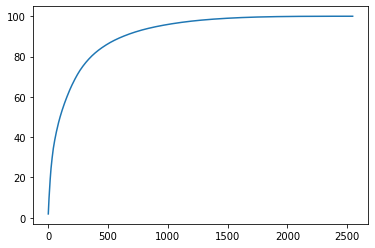

Group A includes 360 items


In [77]:
# Group A - 80% of the total demand
demands['sum_demands'] = np.sum(demands, axis=1)
demands_sum = demands.iloc[:,[0,-1]]
demands.drop(['sum_demands'], axis=1, inplace=True)
demands_sum.sort_values(by=['sum_demands'], ascending=False, inplace=True)

demands_sum['cumsum'] = demands_sum['sum_demands'].cumsum()
demands_sum['cumsum_perc'] = 100 * demands_sum['cumsum'] / demands_sum['sum_demands'].sum()

# fig = plt.figure(dpi=60, figsize=(10, 7))
plt.plot(np.arange(len(demands_sum['cumsum_perc'])),demands_sum['cumsum_perc'])
# plt.xlabel = 'Longitude'
# plt.ylabel = 'Latitude'
# plt.title('xlabels() function')
plt.show()
demands_sum['Up_To'] = demands_sum['cumsum_perc'] <= 80
good_sku_ids = demands_sum[demands_sum['Up_To']]
a_list_sku_ids = good_sku_ids['SKU_ID']
print(f'Group A includes {len(list(a_list_sku_ids))} items')

In [78]:
# Leave the SKU id's demands of group A
demands = demands[demands["SKU_ID"].isin(list(a_list_sku_ids))]

In [79]:
# Intersection of demands with all files
demands = demands[demands['SKU_ID'].isin(initial_inventory["SKU_ID"])]
demands = demands[demands['SKU_ID'].isin(daily_demands_22["SKU_ID"])]
demands = demands[demands['SKU_ID'].isin(refresh["SKU_ID"])]
demands = demands[demands['SKU_ID'].isin(volumes["SKU_ID"])]

In [80]:
# Make 3 lists - less (r<9.5), good (9.5<r>10.5), more (r>10.5) while r is the number of refreshes per month
refresh['mean'] = np.mean(refresh.iloc[:,1:].to_numpy(),axis=1)
sku_ids_0to95 = list(refresh[(refresh['mean']>=0)&(refresh['mean']<9.5)]['SKU_ID'])
sku_ids_95to105 = list(refresh[(refresh['mean']>=9.5)&(refresh['mean']<=10.5)]['SKU_ID'])
sku_ids_over105 = list(refresh[refresh['mean']>10.5]['SKU_ID'])

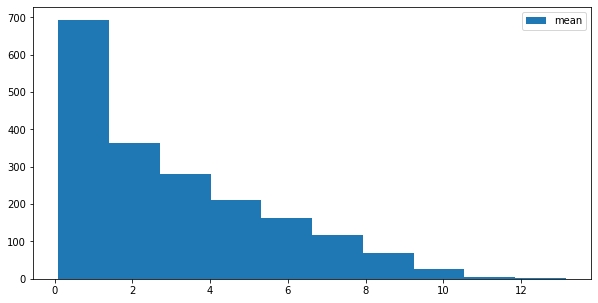

In [81]:
hist = refresh['mean'].hist(bins=10,grid=False,figsize=[10,5],legend=True)

In [82]:
lst1 = list(demands['SKU_ID']) # create a list of our SKU IDs
lst2 = sku_ids_0to95 + sku_ids_over105 # create a list of SKU IDs with an unsatisfactory amount of refreshes
relevant_sku_ids = list(set(lst1) & set(lst2)) # sku_ids of products that are not good (less or more)
print(f'The number of relevant sku_ids is: {len(relevant_sku_ids)}')

The number of relevant sku_ids is: 226


In [83]:
demands = demands[demands['SKU_ID'].isin(relevant_sku_ids)]
initial_inventory = initial_inventory[initial_inventory['SKU_ID'].isin(relevant_sku_ids)]
daily_demands_22 = daily_demands_22[daily_demands_22['SKU_ID'].isin(relevant_sku_ids)]
refresh = refresh[refresh['SKU_ID'].isin(relevant_sku_ids)]
volumes = volumes[volumes['SKU_ID'].isin(relevant_sku_ids)]

In [84]:
demands

,SKU_ID,'01','02','03','04','05','06','07','08','09','10','11','12'
12,FC038348,1874.0,1856.0,2234.0,2136.0,2126.0,2253.0,2080.0,2475.0,1929.0,2260.0,2286.0,2323.0
41,BI000161,1201.0,2345.0,527.0,758.0,1503.0,758.0,1162.0,1462.0,1844.0,1500.0,1880.0,1281.0
68,GS043189,240.0,2520.0,2112.0,12480.0,0.0,1632.0,3192.0,2592.0,1800.0,4056.0,5352.0,3936.0
71,RAK00001,2499.0,1720.0,4996.0,2305.0,3228.0,5141.0,3504.0,3714.0,2504.0,2946.0,3411.0,4773.0
78,C2241900,4477.0,4803.0,9387.0,11974.0,19149.0,14612.0,3741.0,1142.0,11069.0,5306.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,BI000251,11240.0,4576.0,5255.0,5701.0,3219.0,21.0,78.0,105.0,38.0,148.0,109.0,96.0
2956,ACTAV042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9055.0,1814.0,4563.0,3408.0,4044.0
2957,2AK05630,2785.0,1210.0,1945.0,4310.0,4490.0,970.0,2137.0,1290.0,2650.0,1600.0,410.0,2615.0
2983,RB001603,0.0,1.0,53.0,106.0,90.0,10.0,61.0,2106.0,1316.0,3149.0,4723.0,5084.0


### Min Max

In [17]:
# get the demands fo the last year and the min,max values
# return dictionary when the key is tuple of (sku_id,quarter number) and ......
# the value is tuple of (min,max) like - {('FC038348', 1): (27, 54),('FC038348', 2): (296, 592),.....}
def MinMax(demands,min,max):
    copy = demands.copy()
    columns = ['SKU_ID']
    for i in range(4):
        copy['Min'+str(i+1)] = (copy.iloc[:,i*3+1:i*3+4].mean(axis=1) / 22) * min
        copy['Max'+str(i+1)] = (copy.iloc[:,i*3+1:i*3+4].mean(axis=1) / 22) * max
        columns += ['Min'+str(i+1),'Max'+str(i+1)]
    copy = copy.loc[:,columns]
    dic = defaultdict(tuple)
    for index, row in copy.iterrows():
        for i in range(1,5):
            row = list(row)
            dic[(row[0],i)] = (row[2*i-1],row[2*i])
    return dic

### Simulation

In [18]:
# transfer 'daily_demands_22' into a dictionary structure
daily_demands_22_dic = defaultdict(list)
for index, row in daily_demands_22.iterrows():
    row = list(row)
    daily_demands_22_dic[row[0]] = row[1:]

In [19]:
# transfer 'initial_inventory' into a dictionary structure
initial_inventory_dic = defaultdict(list)
for index, row in initial_inventory.iterrows():
    row = list(row)
    initial_inventory_dic[row[0]] = row[1]

In [20]:
# transfer 'volumes' into a dictionary structure
volumes_dic = defaultdict(list)
for index, row in volumes.iterrows():
    row = list(row)
    volumes_dic[row[0]] = row[1]

In [21]:
def calc_capacity_per_arkalit(daily_demands_22_dic,volumes_dic,high_volume, low_volume):
    dic = defaultdict(dict)
    items_sku_ids = list(daily_demands_22_dic.keys())
    for item in items_sku_ids:
        cur_vol = volumes_dic[item]
        dic[item] = {'low_half':int((low_volume/2)/cur_vol), 'low_full':int(low_volume/cur_vol), 'high_half':int((high_volume/2)/cur_vol), 'high_full':int(high_volume/cur_vol)}
    return dic
capacity_per_arkalit = calc_capacity_per_arkalit(daily_demands_22_dic,volumes_dic,30000, 15000)

In [22]:
def calc_initial_inventory(daily_demands_22_dic, initial_inventory, capacity_per_arkalit,arkaliot):
    inventory_dic = defaultdict(dict)
    items_sku_ids = list(daily_demands_22_dic.keys())
    for item in items_sku_ids:
        # capacity = capacity_per_arkalit[item][arkalit_type]
        inventory = initial_inventory[item]
        # required_number_of_arkaliot = math.ceil(inventory/capacity)
        options = ['low_half','low_full','high_half','high_full']
        effective_options = [k for (k, v) in arkaliot.items() if v >= math.ceil(inventory/capacity_per_arkalit[item][k])]
        if not effective_options:
            arkalit_type = choice(options)
        else:
            arkalit_type = choice(effective_options)
        arkaliot[arkalit_type] -= math.ceil(inventory/capacity_per_arkalit[item][arkalit_type])
        inventory_dic[item] = {i: (inventory if i == arkalit_type else 0) for i in options}
    return inventory_dic

# arkaliot = {'low_half':2*int(1383) ,'low_full':int(1476), 'high_half':2*int(3251), 'high_full':int(7247)}
# calc_initial_inventory = initial_inventory(daily_demands_22_dic, initial_inventory_dic, capacity_per_arkalit,arkaliot)

In [23]:
def loading (sku_id,quantity,arkaliot,inventory_dic):
    global count_no_space
    global count_refresh
    effective_options = defaultdict(int)
    flag = False
    for (arkalit_type, num_of_free_arkaliot) in arkaliot.items():
        capacity_of_item_arkalit = capacity_per_arkalit[sku_id][arkalit_type]
        num_of_full_arkaliot = int(math.ceil(inventory_dic[sku_id][arkalit_type] / capacity_of_item_arkalit))
        total_arkaliot = num_of_free_arkaliot + num_of_full_arkaliot
        total_units = total_arkaliot * capacity_of_item_arkalit
        total_units_possible = total_units - inventory_dic[sku_id][arkalit_type]
        if total_units_possible > 0:
            effective_options[arkalit_type] = total_units_possible
    while quantity > 0:
        if not effective_options:
            count_no_space += 1
            break
        else:
            flag = True
            arkalit_type = choice(list(effective_options.keys()))
            possible_loading = effective_options[arkalit_type]
            if possible_loading > quantity:
                loading = quantity
                quantity = 0
                effective_options[arkalit_type] -= loading
            else:
                loading = possible_loading
                quantity -= possible_loading
                del effective_options[arkalit_type]

            last_inventory = inventory_dic[sku_id][arkalit_type]
            new_inventory = last_inventory + loading
            capacity = capacity_per_arkalit[sku_id][arkalit_type]
            added_arkaliot = int(math.ceil(new_inventory/capacity) - math.ceil(last_inventory/capacity))  
                
            inventory_dic[sku_id][arkalit_type] = int(new_inventory)   
            arkaliot[arkalit_type] -= added_arkaliot
    if flag:
        count_refresh += 1

In [24]:
# def a():
#     global c
#     c += 1

# def b():
#     c=0
#     a()
# b()
# c

In [25]:
# def how_many_arkaliot (sku_id, type_of_arkalit,inventory_dic):
#     inventory = inventory_dic[sku_id][type_of_arkalit]
#     capacity = capacity_per_arkalit[sku_id][type_of_arkalit]
#     return math.ceil(inventory/capacity)

def pull_out(sku_id,quantity,arkaliot,inventory_dic):
    # effective_options = [k for (k, v) in inventory_dic[sku_id].items() if v > 0]
    global count_no_inventory
    global sum_no_inventory
    while quantity > 0:
        effective_options = [k for (k, v) in inventory_dic[sku_id].items() if v > 0]
        if not effective_options:
            count_no_inventory += 1
            sum_no_inventory += quantity
            break
        arkalit_type = choice(effective_options)
        inventory = inventory_dic[sku_id][arkalit_type]
        capacity = capacity_per_arkalit[sku_id][arkalit_type]
        if inventory % capacity == 0:
            pull_out = capacity
        else:
            pull_out = int(inventory % capacity)
        if pull_out > quantity:
            pull_out = quantity
            quantity = 0
        else:
            quantity -= pull_out
            arkaliot[arkalit_type] += 1
        inventory_dic[sku_id][arkalit_type] -= int(pull_out)

In [26]:
# calc 'others' volume
demands_others = pd.read_excel(open('demands21.xlsx', 'rb'))
volumes_others = pd.read_excel("volume.xlsx")
assuta_items = pd.read_excel("Assuta_items.xlsx")

demands_others.fillna(0,inplace = True)
volumes_others = volumes_others.iloc[:,:2]
volumes_others.rename(columns = {f'{volumes_others.columns[1]}':'volume'}, inplace = True)
assuta_items = pd.DataFrame(assuta_items.iloc[:,0])

demands_others = demands_others[~demands_others.SKU_ID.isin(list(demands.SKU_ID))]
demands_others = demands_others[~demands_others["SKU_ID"].isin(assuta_items["SKU_ID"])]

demands_others['Max'] = (demands_others.mean(axis=1) / 22) * 6
df = pd.merge(demands_others, volumes_others, on='SKU_ID', how='left')
df = df[['SKU_ID','Max','volume']]
low_half_others, low_full_others = (0,0)
for index, row in df.iterrows():
    arkalit_type = choice(['full','half'])
    if row['volume'] > 0:
        if arkalit_type == 'full':
            low_full_others += int(row['Max']/max(1,math.floor(15000 / row['volume'])))
        else:
            low_half_others += int(row['Max']/max(1,math.floor(7500 / row['volume'])))

In [27]:
low_full_others,low_half_others

(3009, 5702)

In [28]:
# remove the 'others' volume (arkaliot)
def remove_other(arkaliot,low_full_others,low_half_others):
    if arkaliot['low_half'] < low_half_others:
        low_full_others += int(math.ceil(0.5 * (low_half_others - arkaliot['low_half'])))
        arkaliot['low_half'] = 0
    else:
        arkaliot['low_half'] -= low_half_others
    if arkaliot['low_full'] < low_full_others:
        arkaliot['high_half'] -= low_full_others - arkaliot['low_full']
        arkaliot['low_full'] = 0
        if arkaliot['high_half'] < 0:
            print(arkaliot['high_half'])
            arkaliot['high_full'] -= int(math.ceil(0.5 * - arkaliot['high_half']))
            arkaliot['high_half'] = 0
            if arkaliot['high_full'] < 0:
                print('There are no arkaliots left')
    else:
        arkaliot['low_full'] -= low_full_others


# arkaliot = {'low_half':10 ,'low_full':15, 'high_half':1, 'high_full':7}
# low_half_others,low_full_others = (9,18)
# remove_other(arkaliot,low_full_others,low_half_others)

# proportion = 0.98 # the proportion of the OSR that can be uesd
# arkaliot = {'low_half':2*int(1383 * proportion) ,'low_full':int(1476 * proportion), 'high_half':2*int(3251 * proportion), 'high_full':int(7247 * proportion)}
# remove_other(arkaliot,low_full_others,low_half_others)

In [29]:
# # check if there is a free space in a specific type of arkalit
# def check_place(sku_id,type_of_arkalit, number_of_units):
#     capacity = 6
#     # capacity = capacity_per_arkalit[sku_id][type_of_arkalit]
#     return (int(number_of_units/capacity),number_of_units%capacity)

In [30]:
# proportion = 0.98 # the proportion of the OSR that can be uesd
# arkaliot = {'low_half':2*int(1383 * proportion) ,'low_full':int(1476 * proportion), 'high_half':2*int(3251 * proportion), 'high_full':int(7247 * proportion)}
# remove_other(arkaliot,low_full_others,low_half_others)

# inventory_dic = calc_initial_inventory(daily_demands_22_dic, initial_inventory_dic, capacity_per_arkalit,arkaliot)

# c=0
# for i,j in inventory_dic.items():
#     for k in j.values():
#         if isinstance(k, float):
#             c+=1
# c

In [31]:
# inventory_dic

In [32]:
# capacity_per_arkalit['2CK13811']

In [33]:
# inventory_dic['2CK13811']

In [34]:
# arkaliot

In [35]:
# loading ('2CK13811',10,arkaliot,inventory_dic)
# inventory_dic

In [36]:
# inventory_dic

In [37]:
# arkaliot

In [38]:
# pull_out('2CK13811',71,arkaliot,inventory_dic)
# inventory_dic

In [39]:
# arkaliot

In [40]:
def simulation (daily_demands:dict,initial_inventory:dict,volumes:dict,minmax:dict,capacity_per_arkalit:dict):
    
    days = len(daily_demands[list(daily_demands.keys())[0]]) # number of days we will run through
    items_sku_ids = list(daily_demands.keys()) # list of sku ids
    refresf_dic = {item:False for item in items_sku_ids} # initialize a dictionary with 'False' value for each sku id
    
    current_day = 0 # holds the day number in each iteration 
    current_quarter = 1 # holds the quarter number in each iteration
    
    global count_no_space
    global count_no_inventory
    global sum_no_inventory
    global count_refresh
    count_no_space = 0 # counter of times we have exceeded the storage capacity
    count_no_inventory = 0 # counter of times we dont have enough inventory to pull out
    sum_no_inventory = 0 # how many units in total we couldnt pull out
    count_refresh = 0 # counter of refreshes
    
    # count_under0 = 0 # counter of times under 0
    # sum_under0 = 0 # sum of units under 0
    
    # OSR_volume = (total_high * 30000 + total_low * 15000) * 0.97 # total volume of the OSR (leave 3% of the storage empty), 15000cc and 30000cc is the volume of low and high 'Arkaliot' respectively
    # free_volume = OSR_volume - others_volume # the free volume we can use
    
    proportion = 0.98 # the proportion of the OSR that can be uesd
    arkaliot = {'low_half':2*int(1383 * proportion) ,'low_full':int(1476 * proportion), 'high_half':2*int(3251 * proportion), 'high_full':int(7247 * proportion)}
    remove_other(arkaliot,low_full_others,low_half_others)
    
    inventory_dic = calc_initial_inventory(daily_demands, initial_inventory, capacity_per_arkalit,arkaliot)
    
    for day in range(days): # go through all days
        total_volume = 0 # sum up the volumes per day
        for item in items_sku_ids: # go through all items
            if refresf_dic[item]: # check if refresh is required for the specific item
                curr_inventory = sum(inventory_dic[item].values()) # current inventory
                new_inventory = minmax[(item,current_quarter)][1] # refresh to maximum
                loading(item,new_inventory-curr_inventory,arkaliot,inventory_dic)
                refresf_dic[item] = False # after refreshing, change again the refresh requirement into 'False' 
            # item_volume = initial_inventory[item] * volumes[item] # calc the item volume based on the existing inventory and the volume per unit
            # total_volume += item_volume # add the item volume to the total volume
            
            pull_out(item,daily_demands[item][day],arkaliot,inventory_dic) # update the inventory

            if sum(inventory_dic[item].values()) < minmax[(item,current_quarter)][0]: # check if inventory is less than the minimum
                refresf_dic[item] = True # change  the refresh requirement into 'True' 
                # count_refresh += 1 # add 1 to the refreshes counter

        current_day += 1 # update the day counter
        if current_day <= 89: current_quarter = 1 # change the quarter according to the day 
        elif current_day <= 180: current_quarter = 2 # change the quarter according to the day
        elif current_day <= 272: current_quarter = 3 # change the quarter according to the day
        else: current_quarter = 4 # change the quarter according to the day
    return count_refresh,count_no_space,count_no_inventory,int(sum_no_inventory)

In [41]:
# def simulation (daily_demands:dict,initial_inventory:dict,volumes:dict,minmax:dict,total_high:int,total_low:int, others_volume:int):
#     days = len(daily_demands[list(daily_demands.keys())[0]]) # number of days we will run through
#     items_sku_ids = list(daily_demands_22_dic.keys()) # list of sku ids
#     refresf_dic = {item:False for item in items_sku_ids} # initialize a dictionary with 'False' value for each sku id
#     current_day = 0 # holds the day number in each iteration 
#     current_quarter = 1 # holds the quarter number in each iteration
#     count_refresh = 0 # counter of refreshes
#     count_under0 = 0 # counter of times under 0
#     sum_under0 = 0 # sum of units under 0
#     OSR_volume = (total_high * 30000 + total_low * 15000) * 0.97 # total volume of the OSR (leave 3% of the storage empty), 15000cc and 30000cc is the volume of low and high 'Arkaliot' respectively
#     free_volume = OSR_volume - others_volume # the free volume we can use
#     for day in range(days): # go through all days
#         total_volume = 0 # sum up the volumes per day
#         for item in items_sku_ids: # go through all items
#             if refresf_dic[item]: # check if refresh is required for the specific item
#                 item_inventory = minmax[(item,current_quarter)][1] # refresh to maximum
#                 initial_inventory[item] = item_inventory
#                 refresf_dic[item] = False # after refreshing, change again the refresh requirement into 'False' 
#             item_volume = initial_inventory[item] * volumes[item] # calc the item volume based on the existing inventory and the volume per unit
#             total_volume += item_volume # add the item volume to the total volume
#             initial_inventory[item] -= daily_demands[item][day] # update the inventory
#             if initial_inventory[item] < 0: # check if inventory is less than 0
#                 # print(f'The inventory of item {item} is less than 0 in day {current_day}') # logging
#                 refresf_dic[item] = True
#                 count_refresh += 1
#                 count_under0 += 1
#                 sum_under0 += -initial_inventory[item]
#             elif initial_inventory[item] < minmax[(item,current_quarter)][0]: # check if inventory is less than the minimum
#                 refresf_dic[item] = True # change  the refresh requirement into 'True' 
#                 count_refresh += 1 # add 1 to the refreshes counter
#             else: # inventory between minimum and maximum
#                 pass
#         if total_volume > free_volume: # check in the end of the day if we have exceeded the storage capacity 
#             print(f'Exceeding the OSR capacity in day {current_day}') # logging
#             return ('current_day',current_day) # return the first day we have exceeded the storage capacity 
#         current_day += 1 # update the day counter
#         if current_day <= 89: current_quarter = 1 # change the quarter according to the day 
#         elif current_day <= 180: current_quarter = 2 # change the quarter according to the day
#         elif current_day <= 272: current_quarter = 3 # change the quarter according to the day
#         else: current_quarter = 4 # change the quarter according to the day
#     return count_refresh,count_under0,sum_under0

In [42]:
# daily_demands_22_dic_copy = daily_demands_22_dic.copy()
# initial_inventory_dic_copy = initial_inventory_dic.copy()
# volumes_dic_copy = volumes_dic.copy()
# minmax = MinMax(demands,3,6)
# minmax_copy = minmax.copy()
# simulation(daily_demands_22_dic_copy,initial_inventory_dic_copy,volumes_dic_copy,minmax_copy,capacity_per_arkalit)

# Comparison

In [45]:
min_options = [3,4]
max_options = [4,5,6,8,10,12,15,18,21,24]
under_10_minmax_options = [(i,j) for i in min_options for j in max_options if j > i and j <= 5] # 3 options
under_minmax_dic = {k:MinMax(demands,k[0],k[1]) for k in under_10_minmax_options}
over_10_minmax_options = [(i,j) for i in min_options for j in max_options if j > i and j >= 6] # 16 options
over_minmax_dic = {k:MinMax(demands,k[0],k[1]) for k in over_10_minmax_options}

under_10_minmax_options = [(i,j) for i in under_10_minmax_options for j in under_10_minmax_options] # 9 (3^2) options
over_10_minmax_options = [(i,j) for i in over_10_minmax_options for j in over_10_minmax_options] # 256 (16^2) options

from tqdm import tqdm
results = []
for under in tqdm(under_10_minmax_options):
    Q1_under_minmax = under[0]
    Q2_under_minmax = under[1]
    dic1 = {k:under_minmax_dic[Q1_under_minmax][k] for k in under_minmax_dic[Q1_under_minmax].keys() if k[1] == 1}
    dic2 = {k:under_minmax_dic[Q2_under_minmax][k] for k in under_minmax_dic[Q2_under_minmax].keys() if k[1] == 2}
    merge_dic_12 = dic1 | dic2
    merge_dic_under = {k:merge_dic_12[k] for k in merge_dic_12.keys() if k[0] in sku_ids_0to95}
    for over in tqdm(over_10_minmax_options):
        Q1_over_minmax = over[0]
        Q2_over_minmax = over[1]
        dic3 = {k:over_minmax_dic[Q1_over_minmax][k] for k in over_minmax_dic[Q1_over_minmax].keys() if k[1] == 1}
        dic4 = {k:over_minmax_dic[Q2_over_minmax][k] for k in over_minmax_dic[Q2_over_minmax].keys() if k[1] == 2}
        merge_dic_34 = dic3 | dic4
        merge_dic_over = {k:merge_dic_34[k] for k in merge_dic_34.keys() if k[0] in sku_ids_over105}
        
        minmax = merge_dic_12 | merge_dic_34
        
        daily_demands_22_dic_copy = daily_demands_22_dic.copy()
        initial_inventory_dic_copy = initial_inventory_dic.copy()
        volumes_dic_copy = volumes_dic.copy()
        minmax_copy = minmax.copy()
        result = simulation(daily_demands_22_dic_copy,initial_inventory_dic_copy,volumes_dic_copy,minmax_copy,capacity_per_arkalit)
        results.append((Q1_under_minmax,Q2_under_minmax,Q1_over_minmax,Q2_over_minmax,result[0],result[1],result[2],result[3]))

[((3, 6), (3, 6))]


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


In [41]:
df = pd.DataFrame(results, columns=['MinMax of Q1 (under 10)', 'MinMax of Q2 (under 10)','MinMax of Q1 (over 10)', 'MinMax of Q2 (over 10)','No. of refreshes','No. of no space','No. of no inventory','sum of missing units'])
df

,MinMax of Q1 (under 10),MinMax of Q2 (under 10),MinMax of Q1 (over 10),MinMax of Q2 (over 10),No. of refreshes,No. of no space,No. of no inventory,sum of missing units
0,"(3, 4)","(3, 4)","(3, 6)","(3, 6)",7829,0,1752,344051
1,"(3, 4)","(3, 4)","(3, 6)","(3, 8)",6657,0,1702,329841
2,"(3, 4)","(3, 4)","(3, 6)","(3, 10)",6052,0,1659,321482
3,"(3, 4)","(3, 4)","(3, 6)","(3, 12)",5705,0,1637,318780
4,"(3, 4)","(3, 4)","(3, 6)","(3, 15)",5374,0,1616,309000
...,...,...,...,...,...,...,...,...
2299,"(4, 5)","(4, 5)","(4, 24)","(4, 12)",2556,0,1234,223945
2300,"(4, 5)","(4, 5)","(4, 24)","(4, 15)",2208,0,1227,220266
2301,"(4, 5)","(4, 5)","(4, 24)","(4, 18)",1998,0,1215,217882
2302,"(4, 5)","(4, 5)","(4, 24)","(4, 21)",1857,0,1212,219043


In [42]:
df.to_csv('results1.csv', index=False)

### ------------------------

### Finish

### ------------------------